In [1]:
import pandas as pd
import numpy as np
import os
import django
from django.db.models import Max, Min, Avg, Q, F
from asgiref.sync import sync_to_async
import tqdm
from collections import defaultdict
from pandarallel import pandarallel
import requests
import json
from matplotlib import pyplot as plt

import ctypes
from ctypes import c_char_p, cdll
GoInt64 = ctypes.c_int64
GoInt = GoInt64
archive_node = "http://localhost:19545"

from etherscan.utils.parsing import ResponseParser as parser
pandarallel.initialize(progress_bar=True)
# os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
# os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
# django.setup()

from debtmonitor.models import *
from datavisualization.models import *
from datastorage.models import *
from debtmonitor.help_function import *

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
token_dict = dict(
    usdc = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
    usdt = '0xdac17f958d2ee523a2206206994597c13d831ec7',
    dai =  '0x6b175474e89094c44da98b954eedeac495271d0f',
    # common collateral asset
    weth = "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
)
decimal_dict = dict(
    usdc = 6,
    usdt = 6,
    dai =  18,
    # common collateral asset
    weth = 18
)

liquidation_threshold_dict = dict(
    usdc = 0.88,
    usdt = None, # not allowed as collateral
    dai =  0.8,
    # common collateral asset
    weth = 0.85
)
revert_token_dict = {v: k for k, v in token_dict.items()}

In [3]:
@sync_to_async
def get_potential_target():
    data = pd.DataFrame(
        list(
            LendingPoolInteraction.objects.all().values()
        )
    )
    return data['on_behalf_of'].unique().tolist()

@sync_to_async
def get_interaction_data(target):
    data = pd.DataFrame(
        list(
            LendingPoolInteraction.objects.filter(
                on_behalf_of=target
            ).annotate(
                 block_num=F('block_number__number'),
            ).all().values()
        )
    )
    return data

@sync_to_async
def get_reserves_status():
    data = pd.DataFrame(
        list(
            ReservesStatus.objects.annotate(
                 block_num=F('block_number__number'),
            ).all().values()
        )
    )
    return data

@sync_to_async
def get_liquidation_call(target=None):
    if target is None:
        data = pd.DataFrame(
            list(
                LiquidationCall.objects.annotate(
                    block_num=F('block_number__number'),
                ).all().values()
            )
        )
    else:
        data = pd.DataFrame(
            list(
                LiquidationCall.objects.filter(
                    on_behalf_of=target
                ).annotate(
                    block_num=F('block_number__number'),
                ).all().values()
            )
        )
    return data


In [4]:
# # log:
# block_number = 14655687
# index = 43


# api_key = 'JSPD2IG21CPF9PHIKQP4IEW9R8KN1NJSYH'

# url = f"https://api.etherscan.io/api?module=proxy\
# &action=eth_getTransactionByBlockNumberAndIndex\
# &tag={hex(block_number)}\
# &index={hex(index)}\
# &apikey={api_key}"

# r = requests.get(url, headers={"User-Agent": ""})
# df = pd.DataFrame(parser.parse(r).items(), columns=['key', 'value'])
# df.set_index('key', inplace=True)
# df

In [5]:

# url = f"https://api.etherscan.io/api\
# ?module=logs\
# &action=getLogs\
# &fromBlock={block_number}\
# &toBlock={block_number}\
# &address=0x7d2768dE32b0b80b7a3454c06BdAc94A69DDc7A9\
# &topic0=0xe413a321e8681d831f4dbccbca790d2952b56f977908e45be37335533e005286\
# &apikey={api_key}"

# r = requests.get(url, headers={"User-Agent": ""})
# log_list = parser.parse(r)
# for log in log_list:
#     if log['logIndex'] == hex(index):
#         break
# df = pd.DataFrame(log.items(), columns=['key', 'value'])
# df.set_index('key', inplace=True)
# print(df.loc['transactionHash'].values[0])
# df

In [6]:
read_from_csv = True

if not read_from_csv:

    # targets = await get_potential_target()
    liquidation_call_df = await get_liquidation_call()
    # liquidation_call_
    targets = set(liquidation_call_df['on_behalf_of'].to_list())
    # targets = list(set(liquidation_call_targets).intersection(set(targets)))

    potential_targets = []
    targets_amount = np.inf
    other_token_tolerance_amount = 0

    for target in tqdm.tqdm(targets):
        interaction_df = await get_interaction_data(target)
        interaction_df = interaction_df[interaction_df['action'] != "LiquidationCall"]
        if interaction_df.shape[0] == 0: continue
        potential = True
        other_token_counter = 0
        for token in set(interaction_df['reserve'].to_list()):
            if token not in token_dict.values():
                other_token_counter += 1
                potential = False
                # break
        if potential or other_token_counter <= other_token_tolerance_amount: 
            potential_targets.append(target)
            # print(target)
            if len(potential_targets) >= targets_amount:
                break
    potential_targets = pd.DataFrame(potential_targets, columns=['on_behalf_of'])
    potential_targets.to_csv("../data/potential_targets.csv")
    # potential_targets
else:
    potential_targets = pd.read_csv("../data/potential_targets.csv", index_col=0)
potential_targets.tail(15)

,on_behalf_of
1369,0x4b86eb4180dd1f8345aa5e36e690d1952891e737
1370,0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11
1371,0xab43805bd19c5068f5c30bc4e5f187e2bb7258be
1372,0xcd5388e76038b9cf94690eb229c4c5c231bc8116
1373,0x82b1ddbb931469fbbb4e833775660fa4ab5b2d21
1374,0x396d2f1b3390771a8ac9dc08fe57b92febba27a5
1375,0xf64cdbd628879e3770cfbb05510fe13acbfdcb32
1376,0xbe96a96e447fd556d2b4b589275442cce4f81473
1377,0x72037f2e46c6efd1c8e57a64bc8c35dee191ad24
1378,0x5c0afc3bfab3492baa1fc2f3c02355df7915398f


In [7]:
target_address = "0x39057008ca34c07eefa5bfe78a27c46db2bd49a2"
target_address = "0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11"


In [8]:
reserves_status = await get_reserves_status()
latest_block_num = reserves_status['block_num'].max()
latest_block_num

15354488

In [9]:
interaction_df = await get_interaction_data(target_address)
interaction_df

,id,block_number_id,index,on_behalf_of,action,reserve,amount,rate_mode,rate,transaction_hash,block_num
0,203214,493120,180,0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11,Deposit,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3.540000e+19,-1,-1.000000e+00,,14296382
1,206781,493120,192,0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11,Borrow,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,4.325926e+10,2,2.619925e+25,,14296382
2,340591,42410,56,0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11,LiquidationCall,-1,-1.000000e+00,-1,-1.000000e+00,,14948373
3,341487,37558,364,0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11,LiquidationCall,-1,-1.000000e+00,-1,-1.000000e+00,,14954818
4,342160,42457,245,0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11,LiquidationCall,-1,-1.000000e+00,-1,-1.000000e+00,,14955749
5,343216,32699,517,0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11,LiquidationCall,-1,-1.000000e+00,-1,-1.000000e+00,,14966481
6,357980,42654,226,0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11,LiquidationCall,-1,-1.000000e+00,-1,-1.000000e+00,,14986064


In [10]:
combine_block_n_index = lambda x: int(str(x['block_num']) + str(x['index']).zfill(6))

In [76]:
until_block_num = latest_block_num
until_block_num = 14947500
until_index = 9999
until_block_n_index = combine_block_n_index({'block_num': until_block_num, 'index': until_index})
liquidation_index = until_index

In [77]:
liquidation_df = await get_liquidation_call(target_address)

# potential = True
# for token in set(interaction_df['reserve'].to_list()):
#     if token not in token_dict.values():
#         potential = False
#         break
# assert potential, "Only support WETH DAI USDT and USDC"

interaction_df = interaction_df['action block_num index on_behalf_of reserve amount rate_mode rate'.split(' ')].copy()
reserves_status = reserves_status[[
    'reserve', 'block_num', 'index',  
    'liquidity_rate', 'stable_borrow_rate', 'variable_borrow_rate', 
    'liquidity_index','variable_borrow_index'
]].copy()
liquidation_df = liquidation_df[[
    'block_num', 'index', 'on_behalf_of', 
    'collateral_asset', 'debt_asset', 'debt_to_cover', 'liquidated_collateral_amount',
    'liquidator', 'receive_atoken']].copy()



interaction_df['block_n_index'] = interaction_df.apply(combine_block_n_index, axis=1)
reserves_status['block_n_index'] = reserves_status.apply(combine_block_n_index, axis=1)
liquidation_df['block_n_index'] = liquidation_df.apply(combine_block_n_index, axis=1)

interaction_df = interaction_df.sort_values('block_n_index').reset_index(drop=True)
reserves_status = reserves_status.sort_values('block_n_index').reset_index(drop=True)


# just give a random reserve address, will be swich in the following part
for index in interaction_df.index:
    if interaction_df.loc[index, 'action'] == "LiquidationCall":
        interaction_df.loc[index, 'reserve'] = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'

# merge
user_df = interaction_df.merge(reserves_status, on=['reserve'], how='left')
change_token_address_to_name = lambda x: revert_token_dict[x] if x in revert_token_dict else x
interaction_df['reserve'] = interaction_df['reserve'].apply(change_token_address_to_name).reset_index(drop=True)
user_df['reserve'] = user_df['reserve'].apply(change_token_address_to_name).reset_index(drop=True)
reserves_status['reserve'] = reserves_status['reserve'].apply(change_token_address_to_name).reset_index(drop=True)

liquidation_df['collateral_asset'] = liquidation_df['collateral_asset'].apply(change_token_address_to_name)
liquidation_df['debt_asset'] = liquidation_df['debt_asset'].apply(change_token_address_to_name)

In [78]:
def get_liquidation_data(df_row):
    df_row = df_row.copy()
    if df_row['action'] != 'LiquidationCall': return df_row
    # collateral
    block_n_index_x = df_row['block_n_index_x']
    liquidation_row = liquidation_df[liquidation_df['block_n_index'] == block_n_index_x]
    collateral_asset = liquidation_row['collateral_asset'].values[0]
    tmp_reserves_status = reserves_status[\
        (reserves_status['reserve'] == collateral_asset) &\
        (reserves_status['block_n_index'] <= block_n_index_x)].copy().sort_values('block_n_index')
    tmp_reserves_status = tmp_reserves_status.iloc[-1, :]

    df_row['block_num_y'] = tmp_reserves_status['block_num']
    df_row['index_y'] = tmp_reserves_status['index']
    df_row['liquidity_rate'] = tmp_reserves_status['liquidity_rate']
    df_row['liquidity_index'] = tmp_reserves_status['liquidity_index']
    df_row['block_n_index_y'] = tmp_reserves_status['block_n_index']

    debt_asset = liquidation_row['debt_asset'].values[0]
    tmp_reserves_status = reserves_status[\
        (reserves_status['reserve'] == debt_asset) &\
        (reserves_status['block_n_index'] <= block_n_index_x)].copy().sort_values('block_n_index')
    tmp_reserves_status = tmp_reserves_status.iloc[-1, :]

    df_row['stable_borrow_rate'] = tmp_reserves_status['stable_borrow_rate']
    df_row['variable_borrow_rate'] = tmp_reserves_status['variable_borrow_rate']
    df_row['variable_borrow_index'] = tmp_reserves_status['variable_borrow_index']
    
    return df_row
    # df_row['block_n_index_x']

In [79]:
# y = reserve update, x = interaction
from_df = user_df[user_df['block_n_index_y'] <= user_df['block_n_index_x']]
from_df = from_df.loc[from_df.groupby('block_n_index_x').block_n_index_y.idxmax()].reset_index(drop=True)
from_df = from_df.apply(get_liquidation_data, axis=1)
# # x = interaction, y = reserve update
# to_df = user_df[user_df['block_n_index_x'] <= user_df['block_n_index_y']]
# to_df = to_df.loc[to_df.groupby('block_n_index_x').block_n_index_y.idxmin()]

print(interaction_df.shape, reserves_status.shape)
from_df.shape #, to_df.shape

(7, 9) (930779, 9)


(2, 17)

In [80]:
from_df

,action,block_num_x,index_x,on_behalf_of,reserve,amount,rate_mode,rate,block_n_index_x,block_num_y,index_y,liquidity_rate,stable_borrow_rate,variable_borrow_rate,liquidity_index,variable_borrow_index,block_n_index_y
0,Deposit,14296382,180,0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11,weth,3.540000e+19,-1,-1.000000e+00,14296382000180,14296382.0,174.0,2.157538e+23,3.662814e+25,5.302514e+24,1.007727e+27,1.010590e+27,1.429638e+13
1,Borrow,14296382,192,0xb1b7f5dd1173c180eba4d91f8e78559e8a0b8b11,usdc,4.325926e+10,2,2.619925e+25,14296382000192,14296382.0,190.0,1.427992e+25,1.030996e+26,2.619925e+25,1.070163e+27,1.098351e+27,1.429638e+13


In [81]:
# class TokenInsufficient(Exception):
#     pass


# a token
collateral_dict = defaultdict(float)
collatearl_able_dict = defaultdict(lambda :True)
variable_debt_dict = defaultdict(float)
stable_debt_dict = defaultdict(lambda : [None, None, None]) # amount, interest, start time

liquidation_pool_target = [
    "ReserveUsedAsCollateralEnabled",
    "ReserveUsedAsCollateralDisabled", 
    "Deposit", 
    "Withdraw",
    "Borrow",
    "Repay",
    # "LiquidationCall",
    "Swap",
]

SECONDS_PER_YEAR = 365 * 24 * 60 * 60
RAY = 1e27

ray_mul = lambda a,b: (a * b + RAY/2) / RAY
ray_div = lambda a,b: (a * RAY + b/2) / b


sub_interaction_df = interaction_df[interaction_df['block_n_index'] <= until_block_n_index].copy()

__library = cdll.LoadLibrary('../eth_crawler/library.so')

get_single_block_time = __library.get_single_block_time
get_single_block_time.argtypes = [c_char_p, GoInt]
get_single_block_time.restype = c_char_p

# Block Time
def get_block_time(block_num):
    try:
        res = get_single_block_time(
            archive_node.encode(), 
            GoInt(int(block_num))
        )
        res = res.decode("utf-8")
        res = json.loads(s=res)#.items()#, columns=['BlockNum', 'Timestamp'])
        
        return res[str(block_num)]
    except Exception as e: 
        print(e)


def cal_stable_debt_change(stable_debt_amount_p, stable_borrow_rate_p, block_num, block_num_p):
    block_time = get_block_time(block_num)
    block_time_p = get_block_time(block_num_p)
    exp = block_time - block_time_p
    
    ###### Reference #####: https://etherscan.io/address/0xc6845a5c768bf8d7681249f8927877efda425baf#code
    expMinusOne = exp - 1
    expMinusTwo = exp - 2 if exp > 2 else 0
    ratePerSecond = stable_borrow_rate_p / SECONDS_PER_YEAR
    basePowerTwo = ray_mul(ratePerSecond, ratePerSecond) # (ratePerSecond * ratePerSecond + 0.5 * RAY)/RAY
    basePowerThree = ray_mul(basePowerTwo, ratePerSecond)#  + 0.5 * RAY)/RAY
    secondTerm = (exp * expMinusOne * basePowerTwo) / 2
    thirdTerm = (exp * expMinusOne * expMinusTwo * basePowerThree) / 6
    compounded_interest = RAY + (ratePerSecond * exp) + (secondTerm) + (thirdTerm)
    new_stable_balance = ray_mul(stable_debt_amount_p, compounded_interest)
    balance_increase = new_stable_balance - stable_debt_amount_p
    ########################################################################

    return new_stable_balance, balance_increase

def update_target_debt_data(action_i, block_num, amount_i, token_name_i, 
        rate_mode_i, liquidity_index, variable_borrow_index, stable_borrow_rate):
    
    
    # ['int', 'liquidityRate'],  # 存钱利息
    # ['int', 'stableBorrowRate'],  # 固定贷款利息
    # ['int', 'variableBorrowRate'], # 可变贷款利息
    # ['int', 'liquidityIndex'], # 存钱token价值指数
    # ['int', 'variableBorrowIndex'], # 可变贷款token价值指数
    # stable = 1, variable = 2
    
    a_token_amount_i = ray_div(amount_i, liquidity_index)
    
    variable_debt_amount_i = ray_div(amount_i, variable_borrow_index)

    # For Stable Debt
    stable_debt_amount_i = amount_i #/ stable_borrow_rate
    stable_debt_amount_p, stable_borrow_rate_p, block_num_p = stable_debt_dict[token_name_i]
    if stable_debt_amount_p != None:
        new_stable_balance, balance_increase = cal_stable_debt_change(stable_debt_amount_p, stable_borrow_rate_p, block_num, block_num_p)

    # block_time = get_block_time(block_num)
    # block_time_p = get_block_time(block_num_p)
    # exp = block_time - block_time_p
    
    # ###### Reference #####: https://etherscan.io/address/0xc6845a5c768bf8d7681249f8927877efda425baf#code
    # expMinusOne = exp - 1
    # expMinusTwo = exp - 2 if exp > 2 else 0
    # ratePerSecond = stable_borrow_rate_p / SECONDS_PER_YEAR
    # basePowerTwo = ray_mul(ratePerSecond, ratePerSecond) # (ratePerSecond * ratePerSecond + 0.5 * RAY)/RAY
    # basePowerThree = ray_mul(basePowerTwo, ratePerSecond)#  + 0.5 * RAY)/RAY
    # secondTerm = (exp * expMinusOne * basePowerTwo) / 2
    # thirdTerm = (exp * expMinusOne * expMinusTwo * basePowerThree) / 6
    # compounded_interest = RAY + (ratePerSecond * exp) + (secondTerm) + (thirdTerm)
    # new_stable_balance = ray_mul(stable_debt_amount_p, compounded_interest)
    # balance_increase = new_stable_balance - stable_debt_amount_p
    # ########################################################################
    
    if action_i == "ReserveUsedAsCollateralEnabled":
        collatearl_able_dict[token_name_i] = True
    elif action_i == "ReserveUsedAsCollateralDisabled":
        collatearl_able_dict[token_name_i] = False
    elif action_i == "Deposit":
        if collatearl_able_dict[token_name_i] == False and collateral_dict[token_name_i] == 0:
            collatearl_able_dict[token_name_i] = True
        collateral_dict[token_name_i] += a_token_amount_i
    elif action_i == 'Withdraw':
        if (collateral_dict[token_name_i] - a_token_amount_i) < 0:
            return False, np.abs(collateral_dict[token_name_i] - a_token_amount_i)
        collateral_dict[token_name_i] -= a_token_amount_i
    elif action_i == "Borrow":
        if rate_mode_i == '1': # stable
            if stable_debt_dict[token_name_i][0] is None:
                stable_debt_dict[token_name_i] = [stable_debt_amount_i, stable_borrow_rate, block_num]
            else:
                stable_debt_dict[token_name_i] = [new_stable_balance + stable_debt_amount_i, stable_borrow_rate, block_num]
        elif rate_mode_i == '2': # variable
            variable_debt_dict[token_name_i] += variable_debt_amount_i
        else:
            assert False, "rate_mode_i error"
    elif action_i == "Repay":
        if rate_mode_i == '1':
            if (new_stable_balance - stable_debt_amount_i) < 0:
                return False, np.abs(new_stable_balance - stable_debt_amount_i)
            stable_debt_dict[token_name_i] = [new_stable_balance - stable_debt_amount_i, stable_borrow_rate, block_num]
        elif rate_mode_i == '2': # variable
            if (variable_debt_dict[token_name_i] - variable_debt_amount_i) < 0:
                return False, np.abs(variable_debt_dict[token_name_i] - variable_debt_amount_i)
            variable_debt_dict[token_name_i] -= variable_debt_amount_i
    elif action_i == 'RebalanceStableBorrowRate':
        stable_debt_dict[token_name_i] = [new_stable_balance, stable_borrow_rate, block_num]
    else:
        assert False, "Interaction Data error"

    return True, 0

def get_token_value(block_num, index, fix_decimal=False):
    # collateral_dict = defaultdict(float)
    # collatearl_able_dict = defaultdict(lambda :True)
    # variable_debt_dict = defaultdict(float)
    # stable_debt_dict = defaultdict(lambda : [None, None, None])
    collateral_in_original_unit = defaultdict(float)
    var_debt_in_original_unit = defaultdict(float)
    sta_debt_in_original_unit = defaultdict(float)

    block_n_index = combine_block_n_index(dict(block_num=block_num, index=index))

    for token_name, able in collatearl_able_dict.items():
        decimal_fixer = 1
        if able:
            tmp_status = reserves_status[(reserves_status['reserve'] == token_name) &\
                 (reserves_status['block_n_index'] <= block_n_index)].copy().sort_values('block_n_index').iloc[-1,:]
            if fix_decimal:
                decimal_fixer = 10 ** decimal_dict[token_name]
            collateral_in_original_unit[token_name] = ray_mul(collateral_dict[token_name], tmp_status["liquidity_index"]) / decimal_fixer
    
    for token_name, able in variable_debt_dict.items():
        decimal_fixer = 1
        tmp_status = reserves_status[(reserves_status['reserve'] == token_name) &\
                 (reserves_status['block_n_index'] <= block_n_index)].copy().sort_values('block_n_index').iloc[-1,:]
        if fix_decimal:
            decimal_fixer = 10 ** decimal_dict[token_name]
        var_debt_in_original_unit[token_name] = ray_mul(variable_debt_dict[token_name], tmp_status["variable_borrow_index"]) / decimal_fixer

    for token_name, stable_debt in stable_debt_dict.items():
        decimal_fixer = 1
        if stable_debt[0] is not None:
            stable_debt_amount_p, stable_borrow_rate_p, block_num_p = stable_debt_dict[token_name]
            new_stable_balance, balance_increase = cal_stable_debt_change(stable_debt_amount_p, stable_borrow_rate_p, block_num, block_num_p)
            if fix_decimal:
                decimal_fixer = 10 ** decimal_dict[token_name]
            sta_debt_in_original_unit[token_name] = new_stable_balance / decimal_fixer
    
    
    
    return collateral_in_original_unit, var_debt_in_original_unit, sta_debt_in_original_unit


for index_i in sub_interaction_df.index:

    action_i = sub_interaction_df.loc[index_i, 'action']
    block_n_index = sub_interaction_df.loc[index_i, 'block_n_index']
    block_num = sub_interaction_df.loc[index_i, 'block_num']
    index = sub_interaction_df.loc[index_i, 'index']

    # block_time = get_block_time(block_num)
    before_data = from_df[from_df['block_n_index_x'] == block_n_index]#['amount'].values[0]
    liquidity_index = before_data['liquidity_index'].values[0]
    variable_borrow_index = before_data['variable_borrow_index'].values[0]
    stable_borrow_rate = before_data['stable_borrow_rate'].values[0]
    
    if action_i == "LiquidationCall":
        'collateral_asset', 'debt_asset', 'debt_to_cover', 'liquidated_collateral_amount',
        liquidation_i = liquidation_df[liquidation_df['block_n_index'] == block_n_index].copy().reset_index(drop=True)
        collateral_asset = liquidation_i.loc[0, 'collateral_asset']
        debt_asset = liquidation_i.loc[0, 'debt_asset']
        debt_to_cover = liquidation_i.loc[0, 'debt_to_cover']
        liquidated_collateral_amount = liquidation_i.loc[0, 'liquidated_collateral_amount']

        # a_token_amount_i = ray_div(liquidated_collateral_amount, liquidity_index)
        # collateral_dict[collateral_asset] -= a_token_amount_i

        collateral_in_original_unit, var_debt_in_original_unit, sta_debt_in_original_unit = get_token_value(block_num, index)

        if var_debt_in_original_unit[debt_asset] < debt_to_cover:
            var_debt_to_liquidate = var_debt_in_original_unit[debt_asset]
            sta_debt_to_repay = debt_to_cover - var_debt_to_liquidate
        else:
            var_debt_to_liquidate = debt_to_cover
            sta_debt_to_repay = 0

        success, remaining_token = update_target_debt_data(
            "Repay", block_num, var_debt_to_liquidate, debt_asset, 
            "2", liquidity_index, variable_borrow_index, stable_borrow_rate)
        assert success

        if sta_debt_to_repay > 0:
            success, remaining_token = update_target_debt_data(
                "Repay", block_num, sta_debt_to_repay, debt_asset, 
                "1", liquidity_index, variable_borrow_index, stable_borrow_rate)
            assert success
        
        success, remaining_token = update_target_debt_data(
                "Withdraw", block_num, liquidated_collateral_amount, collateral_asset, 
                "-1", liquidity_index, variable_borrow_index, stable_borrow_rate)
        assert success

    else:
        amount_i = sub_interaction_df.loc[index_i, 'amount']
        token_name_i = sub_interaction_df.loc[index_i, 'reserve']
        rate_mode_i = sub_interaction_df.loc[index_i, 'rate_mode']

        update_target_debt_data(action_i, block_num, amount_i, token_name_i, 
        rate_mode_i, liquidity_index, variable_borrow_index, stable_borrow_rate)



In [82]:
collateral_dict


defaultdict(float, {'weth': 3.512854819266195e+19})

In [83]:
collatearl_able_dict

defaultdict(<function __main__.<lambda>()>, {'weth': True})

In [84]:
variable_debt_dict

defaultdict(float, {'usdc': 39385647202.34005})

In [85]:
stable_debt_dict

defaultdict(<function __main__.<lambda>()>,
            {'weth': [None, None, None], 'usdc': [None, None, None]})

In [86]:
until_block_num

14947500

In [87]:
token_value_dicts = get_token_value(until_block_num, liquidation_index, fix_decimal=True)
# collateral, var_debt, sta_debt
token_value_dicts = {i:j for i,j in zip(['collateral', 'var_debt', 'sta_debt'], token_value_dicts)}

In [88]:
@sync_to_async
def get_price_data(until_block_num, previous_block = 6424):
    ttt = pd.DataFrame(
        list(
            BlockPrice.objects.filter(
                Q(block_number__number__lte=until_block_num) &
                Q(block_number__number__gte=(until_block_num - previous_block))
            ).annotate(
                block_num=F('block_number__number'),
                oracle_name=F('token_pair__oracle__name'),
                token0 = F('token_pair__token0'),
                token1 = F('token_pair__token1'),
            ).all().values()
        )
    )
    return ttt.sort_values("block_num")

In [89]:
price_data = await get_price_data(until_block_num, previous_block=6424)
price_data['token0'] = price_data['token0'].apply(lambda x: 'weth' if x == 'eth' else x)
price_data['token1'] = price_data['token1'].apply(lambda x: 'weth' if x == 'eth' else x)
price_data = price_data[['block_num', 'oracle_name', 'token0', 'token1', 'current']]
price_data

,block_num,oracle_name,token0,token1,current
0,14941076,uniswapv2,weth,usdt,1674.726242
1,14941078,uniswapv3,weth,usdc,1670.537382
2,14941079,uniswapv3,weth,dai,1670.411577
3,14941082,uniswapv2,weth,usdc,1671.530438
4,14941082,uniswapv3,weth,usdc,1670.591077
...,...,...,...,...,...
11719,14947496,uniswapv2,weth,usdc,1519.731027
11720,14947497,uniswapv3,weth,usdc,1523.400083
11722,14947498,uniswapv3,weth,usdc,1523.250069
11721,14947498,uniswapv2,weth,dai,1520.561905


In [90]:
block_num_df = pd.DataFrame(
    range(
        price_data.block_num.min(), 
        until_block_num + 1
    ),
    columns=['block_num']
)
block_num_df.set_index('block_num', inplace=True)

uniswapv3_price_dict = {}
for token in ['usdt', 'dai', 'usdc']:
    sub_price_df = price_data[(price_data['oracle_name'] == 'uniswapv3') & (price_data['token1'] == token)].copy()
    sub_price_df[f'{token}'] = 1/sub_price_df['current']
    sub_price_df.set_index('block_num', inplace=True)
    sub_price_df = sub_price_df.merge(block_num_df, how='right', left_index=True, right_index=True)
    sub_price_df.fillna(method='ffill', inplace=True)
    sub_price_df.fillna(method='bfill', inplace=True)
    uniswapv3_price_dict[token] = sub_price_df[token]
chainlink_price_dict ={}
for token in ['usdt', 'dai', 'usdc']:
    sub_price_df = price_data[(price_data['oracle_name'] == 'chainlink') & (price_data['token0'] == token)].copy()
    sub_price_df[f'{token}'] = sub_price_df['current']
    sub_price_df.set_index('block_num', inplace=True)
    sub_price_df = sub_price_df.merge(block_num_df, how='right', left_index=True, right_index=True)
    sub_price_df.fillna(method='ffill', inplace=True)
    sub_price_df.fillna(method='bfill', inplace=True)
    chainlink_price_dict[token] = sub_price_df[token]

uniswapv3_price_dict

{'usdt': block_num
 14941076    0.000599
 14941077    0.000599
 14941078    0.000599
 14941079    0.000599
 14941080    0.000599
               ...   
 14947496    0.000656
 14947497    0.000656
 14947498    0.000656
 14947499    0.000656
 14947500    0.000656
 Name: usdt, Length: 6425, dtype: float64,
 'dai': block_num
 14941076    0.000599
 14941077    0.000599
 14941078    0.000599
 14941079    0.000599
 14941080    0.000599
               ...   
 14947496    0.000657
 14947497    0.000657
 14947498    0.000657
 14947499    0.000657
 14947500    0.000657
 Name: dai, Length: 6425, dtype: float64,
 'usdc': block_num
 14941076    0.000599
 14941077    0.000599
 14941078    0.000599
 14941079    0.000599
 14941080    0.000599
               ...   
 14947496    0.000656
 14947497    0.000656
 14947498    0.000656
 14947499    0.000656
 14947500    0.000656
 Name: usdc, Length: 6425, dtype: float64}

In [91]:
collatearl_in_eth = 0
debt_in_eth = 0
for token_name, token_amount in token_value_dicts['collateral'].items():
    if token_name == 'weth':
        collatearl_in_eth += token_amount
    else:
        collatearl_in_eth += token_amount * chainlink_price_dict[token_name].loc[until_block_num]

for token_name, token_amount in token_value_dicts['var_debt'].items():
    if token_name == 'weth':
        debt_in_eth += token_amount
    else:
        debt_in_eth += token_amount * chainlink_price_dict[token_name].loc[until_block_num]

for token_name, token_amount in token_value_dicts['sta_debt'].items():
    if token_name == 'weth':
        debt_in_eth += token_amount
    else:
        debt_in_eth += token_amount * chainlink_price_dict[token_name].loc[until_block_num]
collatearl_in_eth, debt_in_eth

(35.443784075993165, 28.55700225697978)

In [92]:
chainlink_price_dict[token_name]

block_num
14941076    0.000605
14941077    0.000605
14941078    0.000605
14941079    0.000605
14941080    0.000605
              ...   
14947496    0.000655
14947497    0.000655
14947498    0.000655
14947499    0.000655
14947500    0.000655
Name: usdc, Length: 6425, dtype: float64

In [93]:
collatearl_m_threshold_in_eth = 0
debt_m_threshold_in_eth = 0
for token_name, token_amount in token_value_dicts['collateral'].items():
    if token_name == 'weth':
        collatearl_m_threshold_in_eth += token_amount * liquidation_threshold_dict[token_name]
    else:
        collatearl_m_threshold_in_eth += token_amount * chainlink_price_dict[token_name].loc[until_block_num]  * liquidation_threshold_dict[token_name]

for token_name, token_amount in token_value_dicts['var_debt'].items():
    if token_name == 'weth':
        debt_m_threshold_in_eth += token_amount
    else:
        debt_m_threshold_in_eth += token_amount * chainlink_price_dict[token_name].loc[until_block_num]

for token_name, token_amount in token_value_dicts['sta_debt'].items():
    if token_name == 'weth':
        debt_m_threshold_in_eth += token_amount
    else:
        debt_m_threshold_in_eth += token_amount * chainlink_price_dict[token_name].loc[until_block_num]
collatearl_m_threshold_in_eth, debt_m_threshold_in_eth

HF = (collatearl_m_threshold_in_eth/debt_m_threshold_in_eth)
HF

1.0549852604795247

In [94]:
# def train_var(tmp_df):
#     tmp_df = tmp_df.copy().set_index('block_num')
#     tmp_df = np.log(tmp_df)
#     log_f_diff = tmp_df.diff().dropna() 
#     log_f_diff = log_f_diff.reset_index(drop=True)
    
#     # VAR irf model
#     return get_var_result(log_f_diff)

In [95]:
used_token_list = []
price_data_list = []
price_name_list = []
for asset_from in ['collateral', 'var_debt', 'sta_debt']:
    for token_name in ['usdc', 'usdt', 'dai']:
    # for token_name, token_amount in token_value_dicts[asset_from].items():
        if token_name == 'weth': continue
        if token_name not in used_token_list:
            used_token_list.append(token_name)
            price_data_list.append(chainlink_price_dict[token_name])
            price_name_list.append(f'chainlink_{token_name}')
            price_data_list.append(uniswapv3_price_dict[token_name])
            price_name_list.append(f'uniswapv3_{token_name}')
var_train_df = pd.concat(price_data_list, axis=1)
var_train_df.columns = price_name_list
var_train_df = var_train_df.reset_index(drop=False)
var_train_df

,block_num,chainlink_usdc,uniswapv3_usdc,chainlink_usdt,uniswapv3_usdt,chainlink_dai,uniswapv3_dai
0,14941076,0.000605,0.000599,0.000601,0.000599,0.000605,0.000599
1,14941077,0.000605,0.000599,0.000601,0.000599,0.000605,0.000599
2,14941078,0.000605,0.000599,0.000601,0.000599,0.000605,0.000599
3,14941079,0.000605,0.000599,0.000601,0.000599,0.000605,0.000599
4,14941080,0.000605,0.000599,0.000601,0.000599,0.000605,0.000599
...,...,...,...,...,...,...,...
6420,14947496,0.000655,0.000656,0.000658,0.000656,0.000658,0.000657
6421,14947497,0.000655,0.000656,0.000658,0.000656,0.000658,0.000657
6422,14947498,0.000655,0.000656,0.000658,0.000656,0.000658,0.000657
6423,14947499,0.000655,0.000656,0.000658,0.000656,0.000658,0.000657


# train and test

In [96]:
train_test_split = 1
train_data = var_train_df[:(int(len(var_train_df)*train_test_split)+1)].set_index('block_num')
test_data = var_train_df[(int(len(var_train_df)*train_test_split)+1):].set_index('block_num')
tmp_df = train_data.copy()#.set_index('block_num')
# log_df = np.log(tmp_df)
log_f_diff = tmp_df.diff().dropna() 
log_f_diff = log_f_diff.reset_index(drop=True)
trained_var = get_var_result(log_f_diff)

<AxesSubplot:xlabel='block_num'>

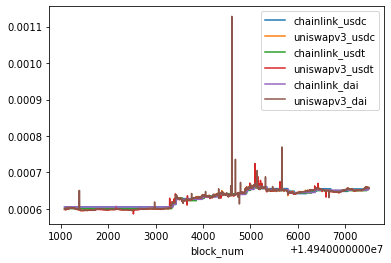

In [97]:
train_data.plot()

<AxesSubplot:>

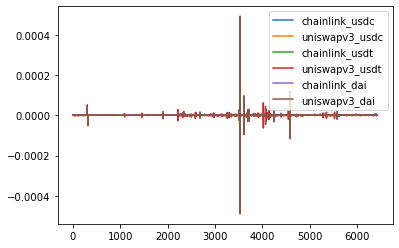

In [98]:
log_f_diff.plot()

In [99]:
log_f_diff

,chainlink_usdc,uniswapv3_usdc,chainlink_usdt,uniswapv3_usdt,chainlink_dai,uniswapv3_dai
0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
1,0.0,0.000000e+00,0.0,0.0,0.0,0.0
2,0.0,0.000000e+00,0.0,0.0,0.0,0.0
3,0.0,0.000000e+00,0.0,0.0,0.0,0.0
4,0.0,0.000000e+00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
6419,0.0,0.000000e+00,0.0,0.0,0.0,0.0
6420,0.0,-7.976988e-09,0.0,0.0,0.0,0.0
6421,0.0,6.464639e-08,0.0,0.0,0.0,0.0
6422,0.0,0.000000e+00,0.0,0.0,0.0,0.0


In [100]:
trained_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 17, Aug, 2022
Time:                     10:56:23
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -165.636
Nobs:                     6333.00    HQIC:                  -167.923
Log likelihood:           484933.    FPE:                3.51935e-74
AIC:                     -169.136    Det(Omega_mle):     2.14086e-74
--------------------------------------------------------------------
Results for equation chainlink_usdc
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.000000         0.000000            0.066           0.948
L1.chainlink_usdc         -0.028272         0.013151           -2.150           0.032
L1.uniswapv3_usdc         -0.03

In [101]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)] = (df_train[col].iloc[-1] + df_fc[col].cumsum()) # np.exp(df_train[col].iloc[-1] + df_fc[col].cumsum())
    return df_fc

In [102]:
def cal_hf(price_prediction, token_value_dicts, liquidation_threshold_dict):
    hf_list = []
    for i in range(price_prediction.shape[0]):
        collatearl_m_threshold_in_eth = 0
        debt_m_threshold_in_eth = 0
        for token_name, token_amount in token_value_dicts['collateral'].items():
            if token_name == 'weth':
                collatearl_m_threshold_in_eth += token_amount * liquidation_threshold_dict[token_name]
            else:
                collatearl_m_threshold_in_eth += token_amount * price_prediction['chainlink_' + token_name].loc[i]  * liquidation_threshold_dict[token_name]

        for token_name, token_amount in token_value_dicts['var_debt'].items():
            if token_name == 'weth':
                debt_m_threshold_in_eth += token_amount
            else:
                debt_m_threshold_in_eth += token_amount * price_prediction['chainlink_' + token_name].loc[i]

        for token_name, token_amount in token_value_dicts['sta_debt'].items():
            if token_name == 'weth':
                debt_m_threshold_in_eth += token_amount
            else:
                debt_m_threshold_in_eth += token_amount * price_prediction['chainlink_' + token_name].loc[i]
        collatearl_m_threshold_in_eth, debt_m_threshold_in_eth

        hf = (collatearl_m_threshold_in_eth/debt_m_threshold_in_eth)
        hf_list.append(hf)
    return pd.Series(hf_list)#, columns=['hf'])

In [103]:
simulate_amount = 1000
simulate_list = []
for i in tqdm.tqdm(range(simulate_amount)):
    price_diff_prediction = pd.DataFrame(trained_var.simulate_var(240), columns=log_f_diff.columns)
    price_prediction = invert_transformation(tmp_df, price_diff_prediction) 
    hf_df = cal_hf(price_prediction, token_value_dicts, liquidation_threshold_dict)
    simulate_list.append(hf_df)
pd.concat(simulate_list, axis=1)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.11it/s]


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.054985,1.054985,1.054985,1.054985,1.054985,1.054985,1.054985,1.054985,1.054985,1.054985,...,1.054985,1.054985,1.054985,1.054985,1.054985,1.054985,1.054985,1.054985,1.054985,1.054985
1,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,...,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984
2,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,...,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984,1.054984
3,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,...,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983
4,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,...,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983,1.054983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.060001,1.059097,1.060815,1.065294,1.057821,1.059690,1.059562,1.054101,1.057422,1.055695,...,1.061103,1.058748,1.059519,1.053754,1.060597,1.047774,1.041431,1.061329,1.046614,1.062208
236,1.059775,1.058792,1.060463,1.064880,1.056196,1.059506,1.059529,1.054112,1.057569,1.056807,...,1.061829,1.059521,1.059068,1.053766,1.061009,1.048303,1.041272,1.060737,1.046444,1.061754
237,1.059694,1.058261,1.060481,1.064516,1.056589,1.059071,1.058949,1.054029,1.057766,1.056022,...,1.061716,1.059171,1.058937,1.054317,1.061421,1.049523,1.041443,1.060195,1.046709,1.061415
238,1.060115,1.057782,1.060501,1.064145,1.056419,1.058820,1.058373,1.053686,1.057073,1.055715,...,1.062924,1.059319,1.059862,1.054766,1.061717,1.049961,1.041878,1.060333,1.047193,1.061353


In [104]:
def mc_simulate(df, step=240):
    price_diff_prediction = pd.DataFrame(trained_var.simulate_var(step), columns=log_f_diff.columns)
    price_prediction = invert_transformation(tmp_df, price_diff_prediction) 
    hf_df = cal_hf(price_prediction, token_value_dicts, liquidation_threshold_dict)
    return hf_df

def cal_pct_be_liquidated(mc_simulation_row):
    return (mc_simulation_row < 1).sum()/mc_simulation_row.count()



<AxesSubplot:>

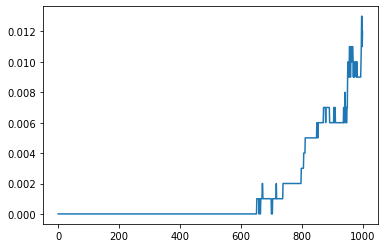

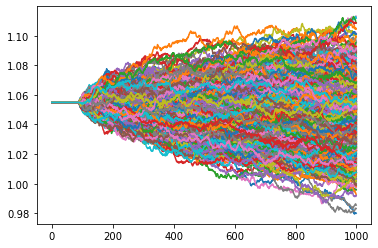

In [105]:
mc_amount = 1000
step = 1000
mc_hf = pd.DataFrame(range(mc_amount)).parallel_apply(mc_simulate, args=(step,), axis=1).T
potential_liquidation = mc_hf.parallel_apply(lambda x: (x < 1).any(), axis=0)
ttt = mc_hf.parallel_apply(cal_pct_be_liquidated, axis=1)
ttt.plot()
mc_hf.plot(legend=False)

Text(0, 0.5, 'Pct of HF < 1')

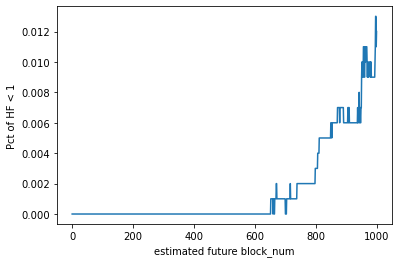

In [106]:
ax = ttt.plot(legend=False)
ax.set_xlabel("estimated future block_num")
ax.set_ylabel("Pct of HF < 1")

In [ ]:
mc_hf.plot(legend=False)

In [ ]:
ttt = mc_hf.parallel_apply(cal_pct_be_liquidated, axis=1)
ttt.to_list()

In [ ]:
potential_liquidation

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Length: 1000, dtype: bool

0     1.000
1     1.000
2     1.000
3     1.000
4     1.000
      ...  
95    0.951
96    0.946
97    0.945
98    0.943
99    0.949
Length: 100, dtype: float64

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Length: 1000, dtype: bool

In [ ]:
def cal_p_be_liquidated(df):
    return df.parallel_apply(lambda x: (x < 1).any(), axis=1)

<AxesSubplot:>

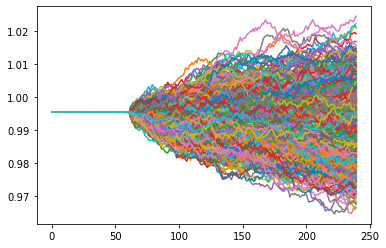

In [ ]:
pd.concat(simulate_list, axis=1).plot(legend=False)

In [ ]:
lag_order = trained_var.k_ar
lag_order

88

In [ ]:
forecast_input = log_f_diff.values[-lag_order:]
forecast_input

array([[ 0.00000000e+00,  4.88336753e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.75170882e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.80750373e-09,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  9.03328929e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  4.71330014e-08,  0.000

$$
\mathrm{MSE}(h) = \sum_{i=0}^{h-1} \Phi \Sigma_u \Phi^T

$$

In [ ]:
forcast_step = 240 #* 10
alpha = 0.1
fc, lower_fc, upper_fc = trained_var.forecast_interval(y=forecast_input, steps=forcast_step, alpha=alpha)
df_forecast = pd.DataFrame(fc, columns=log_f_diff.columns)
df_forecast_lower = pd.DataFrame(lower_fc, columns=log_f_diff.columns)
df_forecast_upper = pd.DataFrame(upper_fc, columns=log_f_diff.columns)
df_forecast

,chainlink_usdc,uniswapv3_usdc,chainlink_usdt,uniswapv3_usdt,chainlink_dai,uniswapv3_dai
0,2.078009e-08,1.583846e-08,2.666728e-08,1.142005e-07,-1.919362e-08,-1.069056e-07
1,-6.116725e-09,7.660293e-09,-4.396701e-08,-1.755179e-07,9.248976e-09,-1.007862e-07
2,-8.475479e-09,-1.388654e-08,-7.064607e-08,1.341677e-07,6.836760e-09,-1.021605e-07
3,4.885579e-08,-4.631142e-08,-8.876210e-09,-2.580781e-07,-2.577108e-08,4.538329e-08
4,-2.128311e-09,1.727315e-08,-3.396139e-08,-1.487773e-07,-4.197246e-08,-4.252003e-07
...,...,...,...,...,...,...
235,5.040218e-09,4.672410e-09,6.344814e-09,1.256511e-08,6.639193e-09,7.535230e-09
236,4.967917e-09,4.549166e-09,6.079488e-09,-1.463462e-09,5.423354e-09,-1.589280e-09
237,5.230321e-09,4.994850e-09,7.244170e-09,9.625207e-09,6.684601e-09,1.142337e-08
238,4.581436e-09,8.939059e-09,5.804557e-09,8.464902e-09,7.061838e-09,1.705505e-08


In [ ]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = (df_train[col].iloc[-1] + df_fc[col].cumsum()) # np.exp(df_train[col].iloc[-1] + df_fc[col].cumsum())
    return df_fc

In [ ]:
# df_results = invert_transformation(log_df, df_forecast) 
df_results = invert_transformation(tmp_df, df_forecast) 
df_upper = invert_transformation(tmp_df, df_forecast_upper) 
df_lower = invert_transformation(tmp_df, df_forecast_lower) 
df_results

,chainlink_usdc,uniswapv3_usdc,chainlink_usdt,uniswapv3_usdt,chainlink_dai,uniswapv3_dai,chainlink_usdc_forecast,uniswapv3_usdc_forecast,chainlink_usdt_forecast,uniswapv3_usdt_forecast,chainlink_dai_forecast,uniswapv3_dai_forecast
0,2.078009e-08,1.583846e-08,2.666728e-08,1.142005e-07,-1.919362e-08,-1.069056e-07,0.000597,0.000598,0.000601,0.000597,0.000598,0.000597
1,-6.116725e-09,7.660293e-09,-4.396701e-08,-1.755179e-07,9.248976e-09,-1.007862e-07,0.000597,0.000598,0.000601,0.000597,0.000598,0.000597
2,-8.475479e-09,-1.388654e-08,-7.064607e-08,1.341677e-07,6.836760e-09,-1.021605e-07,0.000597,0.000598,0.000601,0.000597,0.000598,0.000597
3,4.885579e-08,-4.631142e-08,-8.876210e-09,-2.580781e-07,-2.577108e-08,4.538329e-08,0.000597,0.000598,0.000601,0.000597,0.000598,0.000597
4,-2.128311e-09,1.727315e-08,-3.396139e-08,-1.487773e-07,-4.197246e-08,-4.252003e-07,0.000597,0.000598,0.000600,0.000597,0.000598,0.000597
...,...,...,...,...,...,...,...,...,...,...,...,...
235,5.040218e-09,4.672410e-09,6.344814e-09,1.256511e-08,6.639193e-09,7.535230e-09,0.000598,0.000599,0.000601,0.000598,0.000599,0.000599
236,4.967917e-09,4.549166e-09,6.079488e-09,-1.463462e-09,5.423354e-09,-1.589280e-09,0.000598,0.000599,0.000601,0.000598,0.000599,0.000599
237,5.230321e-09,4.994850e-09,7.244170e-09,9.625207e-09,6.684601e-09,1.142337e-08,0.000598,0.000599,0.000601,0.000598,0.000599,0.000599
238,4.581436e-09,8.939059e-09,5.804557e-09,8.464902e-09,7.061838e-09,1.705505e-08,0.000598,0.000599,0.000601,0.000598,0.000599,0.000599


In [ ]:
df_upper

,chainlink_usdc,uniswapv3_usdc,chainlink_usdt,uniswapv3_usdt,chainlink_dai,uniswapv3_dai,chainlink_usdc_forecast,uniswapv3_usdc_forecast,chainlink_usdt_forecast,uniswapv3_usdt_forecast,chainlink_dai_forecast,uniswapv3_dai_forecast
0,3.904046e-07,6.990577e-07,3.549230e-07,0.000002,2.799512e-07,0.000003,0.000597,0.000599,0.000601,0.000599,0.000599,0.000601
1,3.636341e-07,6.944062e-07,2.847246e-07,0.000001,3.092061e-07,0.000003,0.000598,0.000599,0.000601,0.000600,0.000599,0.000604
2,3.614746e-07,6.782778e-07,2.676713e-07,0.000002,3.069918e-07,0.000003,0.000598,0.000600,0.000602,0.000602,0.000599,0.000607
3,4.197230e-07,6.485046e-07,3.301595e-07,0.000001,2.820533e-07,0.000003,0.000599,0.000601,0.000602,0.000604,0.000599,0.000611
4,3.688470e-07,7.130472e-07,3.053182e-07,0.000002,2.659489e-07,0.000003,0.000599,0.000601,0.000602,0.000605,0.000600,0.000613
...,...,...,...,...,...,...,...,...,...,...,...,...
235,4.215776e-07,7.543211e-07,4.030485e-07,0.000002,3.652240e-07,0.000004,0.000694,0.000773,0.000692,0.001032,0.000682,0.001488
236,4.215058e-07,7.542004e-07,4.027854e-07,0.000002,3.640086e-07,0.000004,0.000694,0.000774,0.000693,0.001034,0.000682,0.001492
237,4.217686e-07,7.546481e-07,4.039514e-07,0.000002,3.652706e-07,0.000004,0.000695,0.000774,0.000693,0.001036,0.000682,0.001496
238,4.211202e-07,7.585933e-07,4.025124e-07,0.000002,3.656486e-07,0.000004,0.000695,0.000775,0.000694,0.001038,0.000683,0.001500


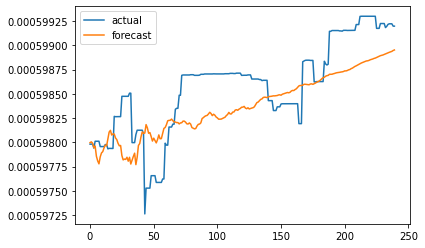

In [ ]:
col_name = 'uniswapv3_usdc'
predict_test_df = pd.concat([df_results[col_name + '_forecast'], test_data[col_name].iloc[:forcast_step].reset_index(drop=True)], axis=1)

# fig, ax = predict_test_df.sub_plot()
fig, ax = plt.subplots()
# ax.set_xlim([0, 1000])
# ax.set_ylim([predict_test_df.min().min(), predict_test_df.max().max()])
ax.plot(predict_test_df.index,predict_test_df[col_name], label='actual')
ax.plot(predict_test_df.index,predict_test_df[col_name + '_forecast'], label='forecast')
ax.legend()

# ax.fill_between(predict_test_df.index, df_lower[col_name + '_forecast'], df_upper[col_name + '_forecast'], color='b', alpha=.1)

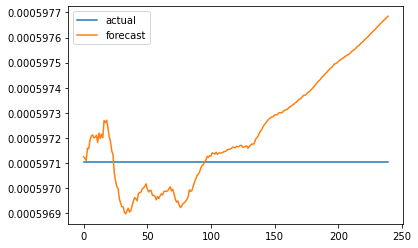

In [ ]:
col_name = 'chainlink_usdc'
predict_test_df = pd.concat([df_results[col_name + '_forecast'], test_data[col_name].iloc[:forcast_step].reset_index(drop=True)], axis=1)

# fig, ax = predict_test_df.sub_plot()
fig, ax = plt.subplots()
# ax.set_xlim([0, 1000])
# ax.set_ylim([predict_test_df.min().min(), predict_test_df.max().max()])
ax.plot(predict_test_df.index,predict_test_df[col_name], label='actual')
ax.plot(predict_test_df.index,predict_test_df[col_name + '_forecast'], label='forecast')
ax.legend()
